In [26]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.dtypes.inference import is_float
from tqdm import tqdm
import json

import sys
sys.path.append("../../sampler/runs/multiPDB_betaSplit_brokenG_1_full/")
from sampler.runs.multiPDB_betaSplit_brokenG_1_full.model_vector import model_vector

path = "../conversion_scripts/multiPDB_betaSplit_brokenG/conversion_dict_inv.json"

with open(path, "r") as f:
    conv = json.load(f)

conv["w"] = "w"

In [28]:
event_samples = pd.read_csv('GW190814_C01:IMRPhenomXPHM.csv.gz')
# population_samples = pd.read_csv("../grid_gamma_low_debug/Farah2022-i-PDB.csv.gz")
population_samples = pd.read_csv("../grid_gamma_low/population2.2.csv.gz")
population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples

requirements = [
    'm_break', 'alpha_1', 'alpha_2', 'gamma_low', 'eta_low', 'gamma_high', 'eta_high', 'A',
    'm_min', 'eta_min', 'm_max', 'eta_max',
    'mu_peak1', 'sig_peak1', 'peak_constant1',
    'mu_peak2', 'sig_peak2', 'peak_constant2',
    'model_min', 'model_max',
    'beta_1', 'beta_2', 'sep',
    'H0', 'Om0', 'w', 'kappa',
    'mu_chi1', 'sig_chi1', 'mix_tilt1', 'sig_tilt1',
    'mu_chi2', 'sig_chi2', 'mix_tilt2', 'sig_tilt2',
    'm_spin_break', 'a_min', 'a_max',
    'costilt_max', 'costilt_min', 'a_max_NS'
]

In [29]:
conv_dict = {"mass1_source":"mass1_source","mass2_source": "mass2_source","redshift":"z","a_1":"spin1_magnitude","costilt1": "spin1_polar_angle","a_2":"spin2_magnitude","costilt2":"spin2_polar_angle"}

_pe = lambda x: event_samples[conv_dict[x]].values.T
z = _pe("redshift"); a1, costilt1 = _pe("a_1"), _pe("costilt1"); a2, costilt2 = _pe("a_2"), _pe("costilt2")
theta_pe = np.array([_pe("mass1_source"), _pe("mass2_source"), z, a1, costilt1, a2, costilt2])
theta_pe = np.expand_dims(theta_pe, axis = 2)
theta_pe.shape

# lnprob_mass1_source = np.log(1 + _pe('redshift'))
# lnprob_mass2_source = np.log(1 + _pe('redshift'))
lnprob_mass1_source = lnprob_mass2_source = 0.1 # No change of units for masses, so no lnprob for masses
lnprob_redshift = 0.1 # No change of units for redshift, so no lnprob for redshift
importance_pe_lnprob_mass_src = lnprob_mass1_source + lnprob_mass2_source
importance_pe_lnprob_spin1_spin2 = 0.1 # No change of units for spins, so no lnprob for spins
importance_pe = importance_pe_lnprob_mass_src + lnprob_redshift + importance_pe_lnprob_spin1_spin2

In [30]:
gamma_low_vals = [2.0, 2.5, 3.0]
num_hyperpost = int(len(population_samples["notch_lowmass_scale"])/1) # len(lambda_pop)
num_events = 1
num_dim = 7

mass2_source_arr = np.zeros((len(gamma_low_vals), num_hyperpost))

for i in tqdm(range(len(gamma_low_vals))):
    population_samples["notch_lowmass_scale"] = np.ones(len(population_samples)) * gamma_low_vals[i]
    population_samples["notch_lowmass_exponent"] = np.ones(len(population_samples)) * 50
    lambda_pop = population_samples[[conv[param] for param in requirements]]
    reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))

    for k in range(num_hyperpost):
        weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
        for j in range(num_events):
            index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
            reweighed_samples[k, j, :] = theta_pe[:, index, j]

    mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
    mass2_source_arr[i] = mass2_source

100%|██████████| 3/3 [04:59<00:00, 99.93s/it] 


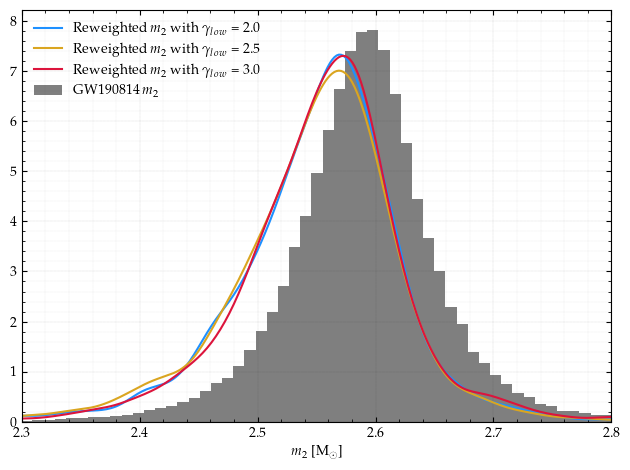

In [31]:
from scipy.stats import gaussian_kde

x = np.linspace(min(event_samples['mass2_source']), max(event_samples['mass2_source']), 1000)

for i in range(mass2_source_arr.shape[0]):
    mass2_source = mass2_source_arr[i]
    kde_mass2 = gaussian_kde(mass2_source)
    kde_values = kde_mass2(x)
    plt.plot(x, kde_values, label=fr"Reweighted $m_2$ with $\gamma_{{low}}$ = {gamma_low_vals[i]:.1f}")

plt.hist(event_samples['mass2_source'], bins=200, density=True, alpha=0.5, label=r'GW190814 $m_2$', color="black")
plt.xlim(2.3, 2.8)
plt.xlabel(r'$m_2$ [M$_\odot$]')
plt.utkarshWrapper()
plt.savefig("mass2_source_reweighing_gamma_low.pdf", bbox_inches='tight')
plt.show()

In [32]:
population_samples = pd.read_csv("../grid_gamma_low/population2.2.csv.gz")
population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples


a_max_vals = [0.3, 0.5, 0.7, 0.9]
num_hyperpost = int(len(population_samples["max_spin2_magnitude_mass2_source_0"])/1) # len(lambda_pop)
num_events = 1
num_dim = 7


mass2_source_arr = np.zeros((len(a_max_vals), num_hyperpost))

for i in tqdm(range(len(a_max_vals))):
    population_samples["max_spin2_magnitude_mass2_source_0"] = np.ones(len(population_samples)) * a_max_vals[i]
    population_samples["max_spin2_magnitude_mass2_source_1"] = np.ones(len(population_samples)) * a_max_vals[i]
    lambda_pop = population_samples[[conv[param] for param in requirements]]
    reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))

    for k in range(num_hyperpost):
        weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
        for j in range(num_events):
            index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
            reweighed_samples[k, j, :] = theta_pe[:, index, j]

    mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
    mass2_source_arr[i] = mass2_source

100%|██████████| 4/4 [06:46<00:00, 101.60s/it]


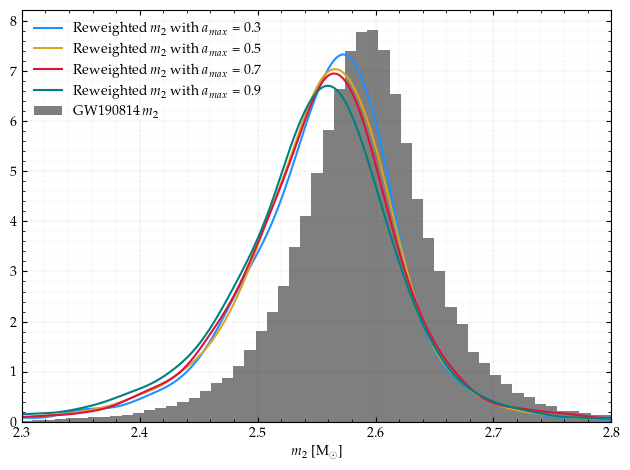

In [33]:
from scipy.stats import gaussian_kde

x = np.linspace(min(event_samples['mass2_source']), max(event_samples['mass2_source']), 1000)

for i in range(mass2_source_arr.shape[0]):
    mass2_source = mass2_source_arr[i]
    kde_mass2 = gaussian_kde(mass2_source)
    kde_values = kde_mass2(x)
    plt.plot(x, kde_values, label=fr"Reweighted $m_2$ with $a_{{max}}$ = {a_max_vals[i]:.1f}")

plt.hist(event_samples['mass2_source'], bins=200, density=True, alpha=0.5, label=r'GW190814 $m_2$', color="black")
plt.xlim(2.3, 2.8)
plt.xlabel(r'$m_2$ [M$_\odot$]')
plt.utkarshWrapper()
plt.savefig("mass2_source_reweighing_a_max.pdf", bbox_inches='tight')
plt.show()